# Implantación de la formación FCN

In [1]:
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\Ульяна\AppData\Local\Temp\ipykernel_18484\2884870189.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


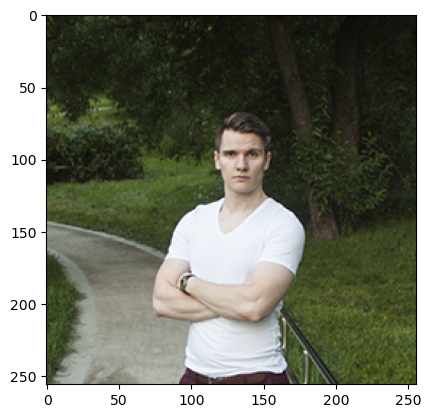

In [9]:
img_path = r"C:\Users\Ульяна\Desktop\jupiter para git\skillbox_neuron_frameworks\para_FNC\6.11_me_256.png"

img = imageio.imread(img_path)
img = img.astype(np.float32) / 255.0
plt.imshow(img)
plt.show()

### Carga y preparación del mapa de segmentación persona/fondo

C:\Users\Ульяна\AppData\Local\Temp\ipykernel_18484\2578785387.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt = imageio.imread(r'C:\Users\Ульяна\Desktop\jupiter para git\skillbox_neuron_frameworks\para_FNC\6.11_me_gt_256.png')


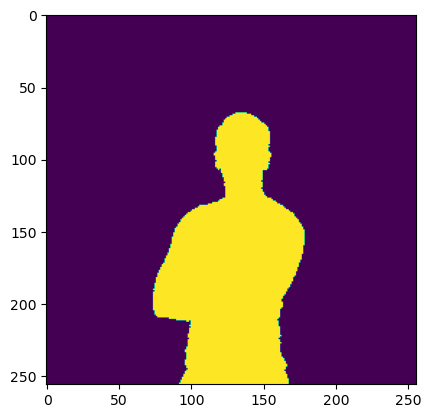

In [11]:
gt = imageio.imread(r'C:\Users\Ульяна\Desktop\jupiter para git\skillbox_neuron_frameworks\para_FNC\6.11_me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_=plt.imshow(gt[...,0])

### Preparar el conjunto de datos de entrenamiento

imagen cargada y su copia reflejada.

Indexar `'::-1'` significa tomar todos los elementos en orden inverso.

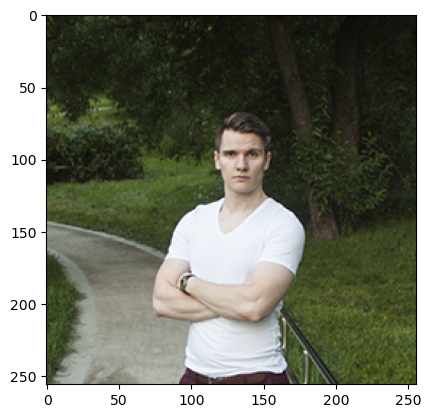

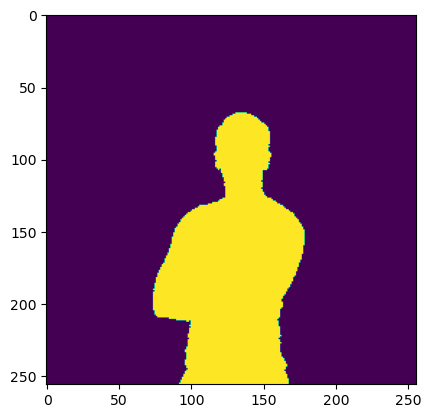

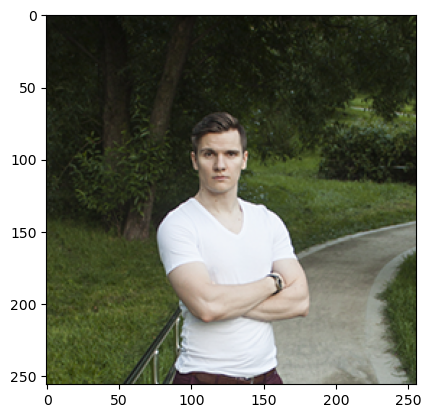

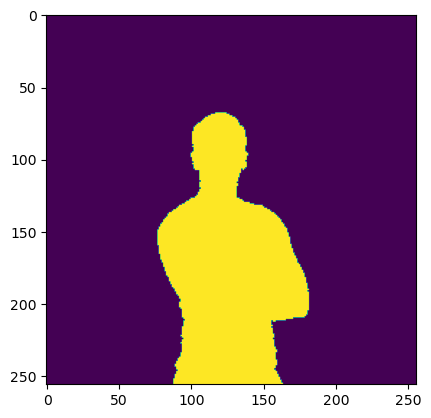

(<matplotlib.image.AxesImage at 0x1bbea63b910>, None)

In [12]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

Podemos organizar una clase así como queramos, pero al menos necesitamos implementar un constructor `__init__()` y una función para la propagación directa (inferencia) de nuestro grafo `call()`. En el constructor creamos las capas y otras cosas que necesitamos. Y en el método `call()` usamos estas capas para calcular la propagación directa (inferencia) de nuestro grafo. Es decir, es en la función `call()` donde se define la arquitectura de nuestra red neuronal escribiendo código al estilo del Python ordinario.

In [13]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = Model()

In [14]:
NUM_EPOCHS = 100

In [15]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

In [16]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)

Epoch 1/100

2/2 [==============================] - 2s 316ms/step - loss: 0.6868
Epoch 2/100
2/2 [==============================] - 1s 349ms/step - loss: 0.6595
Epoch 3/100
2/2 [==============================] - 1s 348ms/step - loss: 0.5890
Epoch 4/100
2/2 [==============================] - 1s 391ms/step - loss: 0.4097
Epoch 5/100
2/2 [==============================] - 1s 465ms/step - loss: 0.2713
Epoch 6/100
2/2 [==============================] - 1s 353ms/step - loss: 0.2216
Epoch 7/100
2/2 [==============================] - 1s 369ms/step - loss: 0.2079
Epoch 8/100
2/2 [==============================] - 1s 411ms/step - loss: 0.2185
Epoch 9/100
2/2 [==============================] - 1s 364ms/step - loss: 0.2112
Epoch 10/100
2/2 [==============================] - 1s 294ms/step - loss: 0.2058
Epoch 11/100
2/2 [==============================] - 1s 364ms/step - loss: 0.2048
Epoch 12/100
2/2 [==============================] - 1s 351ms/step - loss: 0.2008
Epoch 13/100
2/2 [==================

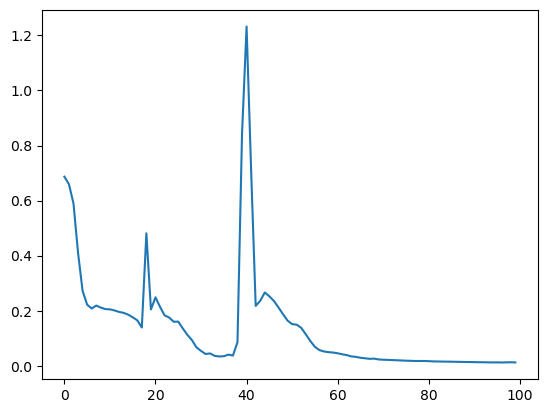

In [17]:
plt.plot(history.history['loss'])

1/1 [==============================] - 0s 206ms/step


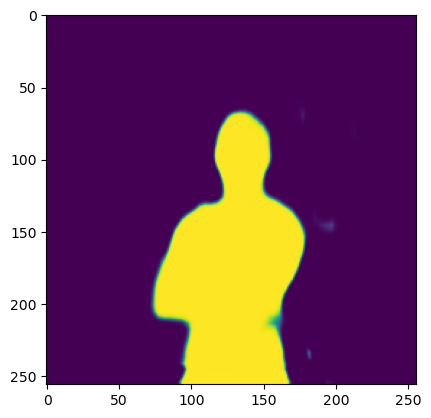

In [18]:
out = model.predict(img[None, ...])
_=plt.imshow(out[0, ..., 0])

### Resultado de la predicción para todas las imágenes
A partir de la predicción de la red, se obtiene un mapa de segmentación mediante umbralización.

1/1 [==============================] - 0s 78ms/step


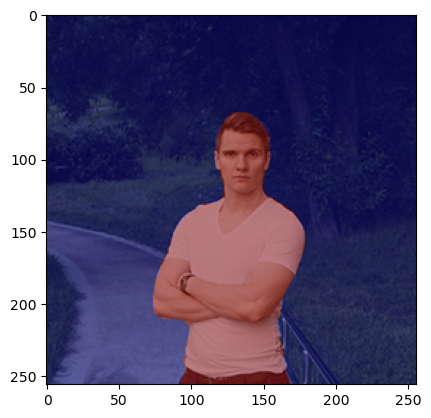

1/1 [==============================] - 0s 85ms/step


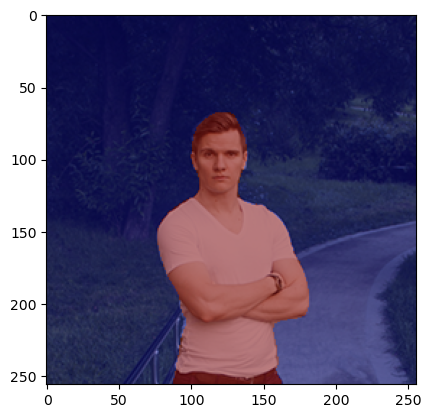

In [19]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('jet')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()